# Preprocessing

In [9]:
# cat vs dogs microsoft dataset
import os
import cv2
import numpy as np
from tqdm import tqdm # used for creating Progress Meters or Progress Bars
import matplotlib.pyplot as plt

REBUILD_DATA = False # set to True if want to preprocess the data

class DogsVSCats():
    IMG_SIZE = 50 # 50x50
    CATS = "../tensorflow/datasets/PetImages/Cat"
    DOGS = "../tensorflow/datasets/PetImages/Dog"
    LABELS = {CATS:0, DOGS:1} # one hot vector is usually better
    training_data = []
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS: # iterating over dirs
            print(label)
            for f in tqdm(os.listdir(label)): # iterating over files
                try:
                    path = os.path.join(label, f)
                    # colors add channels - mostly data we don't need
                    # in nn we want data to be as simple as possible
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    # np.eye() # -> one-hot-vector                    
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
                
                    if label == self.CATS: self.catcount += 1
                    elif label == self.DOGS: self.dogcount += 1
                
                except Exception as e:
                    #print(str(e))
                    pass
                
        np.random.shuffle(self.training_data)
        np.save('training_data.npy', self.training_data)
        print('Cats:', self.catcount, '\nDogs:', self.dogcount)
                
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()
            

In [10]:
training_data = np.load('training_data.npy', allow_pickle=True)
print(training_data[0][1]) # one-hot-vector
training_data[0]

[0. 1.]


array([array([[136,  69, 115, ..., 126, 120, 107],
              [156,  82, 108, ..., 126, 113,  98],
              [171,  90, 101, ..., 119, 106, 137],
              ...,
              [140, 139, 140, ...,  81,  80,  71],
              [141, 139, 138, ...,  60,  87,  86],
              [139, 140, 142, ...,  62,  69,  63]], dtype=uint8),
       array([0., 1.])], dtype=object)

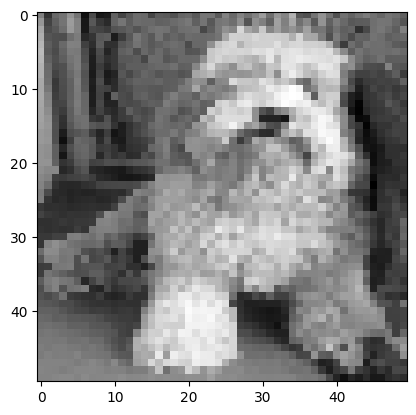

In [3]:
plt.imshow(training_data[0][0], cmap="gray")
plt.show()

# Building neural network

In [2]:
import torch
from torch import nn
from torch.optim import Adam
from torchsummary import summary

In [29]:
class ImgClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, (3,3)), # 5x5 in tutorial
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, (3,3)),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 64, (3,3)),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*9*9, 512),
            nn.ReLU(),
            nn.Linear(512,2)
        )
        
    def forward(self, x):
        # F softmax?
        return self.model(x)
    
    # (50 - 3)/1 + 1 = 48 # conv1
    # (48 - 2)/2 + 1 = 24  # pool
    # (24 - 3)/1 + 1 = 22 # conv2
    # (22 - 2)/2 + 1 = 11 # pool
    # (11 - 3)/1 + 1 = 9 # conv3
# 

In [23]:
clf = ImgClassifier()
opt = Adam(clf.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.MSELoss()

# Training flow
X = torch.Tensor([i[0] for i in training_data]).view(-1, 1, 50, 50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

In [24]:
X.shape

torch.Size([24946, 1, 50, 50])

### Calculating the input of linear layer after convolutions

In [22]:
x = X[:5]
c1 = nn.Conv2d(1,32,(3,3))
p1 = nn.MaxPool2d(2,2)
c2 = nn.Conv2d(32,64,(3,3))
p2 = nn.MaxPool2d(2,2)
c3 = nn.Conv2d(64, 64, (3,3))
print(x.shape)
x = c1(x)
print(x.shape)
x = p1(x)
print(x.shape)
x = c2(x)
print(x.shape)
x = p2(x)
print(x.shape)
x = c3(x)
print(x.shape)
# (50 - 3)/1 + 1 = 48 # conv1
# (48 - 2)/2 + 1 = 24  # pool
# (24 - 3)/1 + 1 = 22 # conv2
# (22 - 2)/2 + 1 = 11 # pool
# (11 - 3)/1 + 1 = 9 # conv3

torch.Size([5, 1, 50, 50])
torch.Size([5, 32, 48, 48])
torch.Size([5, 32, 24, 24])
torch.Size([5, 64, 22, 22])
torch.Size([5, 64, 11, 11])
torch.Size([5, 64, 9, 9])


In [25]:
VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

X_train, y_train = X[:-val_size], y[:-val_size] 
X_test, y_test = X[-val_size:], y[-val_size:]
len(X_train), len(X_test)

2494


(22452, 2494)

In [30]:
BATCH_SIZE = 100 
EPOCHS = 3

training = True

if training:
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(X_train), BATCH_SIZE)):
            X_batch = X_train[i:i+BATCH_SIZE].view(-1,1,50,50)
            y_batch = y_train[i:i+BATCH_SIZE]
            clf.zero_grad()
            output = clf(X_batch) #yhat
            loss = loss_fn(output, y_batch)
            loss.backward()
            opt.step()

    print(loss)

summary(clf, X_test[0].shape)

100%|█████████████████████████████████████████████████████████████████████████████| 225/225 [00:58<00:00,  3.87it/s]

tensor(0.3669, grad_fn=<DivBackward1>)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             320
              ReLU-2           [-1, 32, 48, 48]               0
         MaxPool2d-3           [-1, 32, 24, 24]               0
            Conv2d-4           [-1, 64, 22, 22]          18,496
              ReLU-5           [-1, 64, 22, 22]               0
         MaxPool2d-6           [-1, 64, 11, 11]               0
            Conv2d-7             [-1, 64, 9, 9]          36,928
              ReLU-8             [-1, 64, 9, 9]               0
           Flatten-9                 [-1, 5184]               0
           Linear-10                  [-1, 512]       2,654,720
             ReLU-11                  [-1, 512]               0
           Linear-12                    [-1, 2]           1,026
Total params: 2,711,490
Trainable params: 2,711,490
Non-trainabl

In [11]:
with open('model_state.pt', 'wb') as f:
    torch.save(clf.state_dict(),f)

In [24]:
# model = torch.load('model_state.pt', pickle_module=True)

In [31]:
correct = 0
total = 0

with torch.no_grad():
    for i in tqdm(range(0,len(X_test))):
        real = torch.argmax(y_test[i])
        out = clf(X_test[i].view(-1,1,50,50))[0] # out dla kazdego testu taki sam...
        pred = torch.argmax(out)
        if pred == real: correct+=1
        total += 1
        #print(out)

correct / total

100%|██████████████████████████████████████████████████████████████████████████| 2494/2494 [00:05<00:00, 417.93it/s]


0.785485164394547